In [1]:
from datetime import datetime
from datetime import timedelta
import shapefile
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from pymongo import MongoClient
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
%matplotlib inline

In [2]:
Data=[]
count=[]
inf=open('accidents_by_cell_2hour_day','r')
for line in inf:
    line=line.split(',')
    line[-1]=line[-1][:-1]
    if line[-1]!='accidents':
        Data.append([line[1],int(line[2]),int(line[3]),float(line[4])])
Data=np.array(Data)

In [3]:
Data

array([['2015-03-01 00:00:00', '0', '6', '0.0'],
       ['2015-03-01 02:00:00', '1', '6', '0.0'],
       ['2015-03-01 04:00:00', '2', '6', '0.0'],
       ..., 
       ['2015-04-30 18:00:00', '9', '3', '0.0'],
       ['2015-04-30 20:00:00', '10', '3', '0.0'],
       ['2015-04-30 22:00:00', '11', '3', '0.0']], 
      dtype='|S19')

In [4]:
dates=list(set(Data[:,0]))
datetime_dates=[datetime.strptime( D,'%Y-%m-%d %H:%M:%S') for D in dates]
datetime_dates=np.sort(datetime_dates)
dates=[str(d) for d in datetime_dates]

In [5]:
data=np.array([[datetime_dates[i].weekday(),datetime_dates[i].hour/2,sum(map(float,Data[Data[:,0]==dates[i],3])) ]for i in range(len(dates))])

distribution of n-accidents within an hour


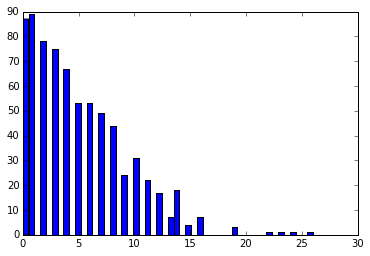

n_accidents  frequency    probability  cumprob     
0            87           11.95        11.95       
1            89           12.23        24.18       
2            78           10.71        34.89       
3            75           10.3         45.19       
4            67           9.2          54.4        
5            53           7.28         61.68       
6            53           7.28         68.96       
7            49           6.73         75.69       
8            44           6.04         81.73       
9            24           3.3          85.03       
10           31           4.26         89.29       
11           22           3.02         92.31       
12           17           2.34         94.64       
13           7            0.96         95.6        
14           18           2.47         98.08       
15           4            0.55         98.63       
16           7            0.96         99.59       
17           0            0.0          99.59       
18          

In [6]:
print('distribution of n-accidents within an hour')
plt.hist(data[:,-1],50)
plt.show()
H=np.histogram(data[:,-1],list(range(20)))
print 'n_accidents'.ljust(12),'frequency'.ljust(12),'probability'.ljust(12),'cumprob'.ljust(12)
for i in range(len(H[1])-1):
    print str(H[1][i]).ljust(12), str(H[0][i]).ljust(12), str(round(100*H[0][i]/float(sum(H[0])),2)).ljust(12),str(round(100*(sum(H[0][:i])+H[0][i])/float(sum(H[0])),2)).ljust(12) 

In [7]:
print 'fascia'.ljust(7),'probability'.ljust(7)
print '0'.ljust(7), str(round(100*H[0][0]/float(sum(H[0])),2)).ljust(7)
print '1'.ljust(7), str(round(100*H[0][1]/float(sum(H[0])),2)).ljust(7)
print '2-3'.ljust(7), str(round(100*sum(H[0][2:4])/float(sum(H[0])),2)).ljust(7)
print '4-5'.ljust(7), str(round(100*sum(H[0][4:6])/float(sum(H[0])),2)).ljust(7)
print '6-7-8'.ljust(7), str(round(100*sum(H[0][6:9])/float(sum(H[0])),2)).ljust(7)
print '>8'.ljust(7), str(round(100*sum(H[0][9:])/float(sum(H[0])),2)).ljust(7)


fascia  probability
0       11.95  
1       12.23  
2-3     21.02  
4-5     16.48  
6-7-8   20.05  
>8      18.27  


In [8]:
Scores=np.zeros(len(data))
i=0
for d in data:
    if d[-1]==0:
        score=0
    elif d[-1]==1:
        score =1
    elif d[-1] in [2,3]:
        score =2
    elif d[-1] in [4,5]:
        score =3
    elif d[-1] in [6,7,8]:
        score =4
    else:
        score =5
    Scores[i]=score
    i+=1
    

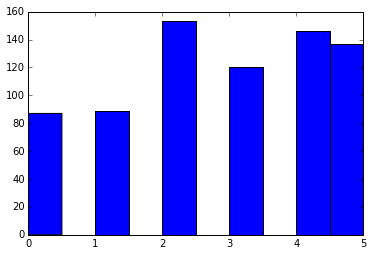

In [9]:
plt.hist(Scores)
plt.show()

In [10]:
I=np.random.permutation(len(data))

choose=0
for choose in [[0],[1],[0,1]]:
    m=[]
    s=[]
    acc=[]
    P=[]
    R=[]
    for i in range(3):
        I_te=list(range(200*i,200*(i+1)))
        I_tr=list(range(0,200*i))+list(range(200*(i+1),len(I)))
        train=I[I_tr]
        test=I[I_te]

        X = np.array([d[choose] for d in data[train]])
        y=Scores[train] 
        clf = svm.SVC()
        clf = clf.fit(X, y)
        true=np.array([int(Scores[t]) for t in test])
        pred=np.array([int(clf.predict([data[t][choose]])[0]) for t in test])
        m.append(np.average(np.abs(true-pred)))
        s.append(np.std(true-pred))
        acc.append(accuracy_score(true,pred))
        conf=confusion_matrix(true,pred) 
        recall=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[i,:]) for i in range(len(conf[:,0]))]
        precision=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[:,i]) for i in range(len(conf[:,0]))]
        R.append(recall)
        P.append(precision)
    R=np.array(R)
    P=np.array(P)
    print '***************\n','features: ',choose,'\naverage values on crossvalidation run\n'
    print 'distance from true: '.ljust(25),round(np.average(m),2)
    print 'std from true: '.ljust(25),round(np.average(s),2)
    print 'accuracy: '.ljust(25),round(np.average(acc),2)
    PP=np.average(P,0)
    RR=np.average(R,0)
    print '\nclass'.ljust(6),'precision'.ljust(10),'recall'.ljust(15)
    for i in range(len(PP) ):
        print str(i).ljust(6),str(round(PP[i],2)).ljust(10),str(round(RR[i],2)).ljust(15)
    print 'avg'.ljust(6),str(round(np.average(PP),2)).ljust(10),str(round(np.average(RR),2)).ljust(15)

***************
features:  [0] 
average values on crossvalidation run

distance from true:       1.7
std from true:            1.99
accuracy:                 0.23

class precision  recall         
0      0.0        0.0            
1      0.0        0.0            
2      0.31       0.49           
3      0.0        0.0            
4      0.17       0.26           
5      0.21       0.42           
avg    0.12       0.19           
***************
features:  [1] 
average values on crossvalidation run

distance from true:       0.93
std from true:            1.29
accuracy:                 0.36

class precision  recall         
0      0.42       0.61           
1      0.05       0.03           
2      0.38       0.39           
3      0.25       0.13           
4      0.32       0.51           
5      0.45       0.46           
avg    0.31       0.36           
***************
features:  [0, 1] 
average values on crossvalidation run

distance from true:       0.89
std from true:          

In [11]:
I=np.random.permutation(len(data))

choose=0
for choose in [[0],[1],[0,1]]:
    m=[]
    s=[]
    acc=[]
    P=[]
    R=[]
    for i in range(3):
        I_te=list(range(200*i,200*(i+1)))
        I_tr=list(range(0,200*i))+list(range(200*(i+1),len(I)))
        train=I[I_tr]
        test=I[I_te]

        X = np.array([d[choose] for d in data[train]])
        y=Scores[train] 
        clf = svm.NuSVC()
        clf = clf.fit(X, y)
        true=np.array([int(Scores[t]) for t in test])
        pred=np.array([int(clf.predict([data[t][choose]])[0]) for t in test])
        m.append(np.average(np.abs(true-pred)))
        s.append(np.std(true-pred))
        acc.append(accuracy_score(true,pred))
        conf=confusion_matrix(true,pred) 
        recall=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[i,:]) for i in range(len(conf[:,0]))]
        precision=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[:,i]) for i in range(len(conf[:,0]))]
        R.append(recall)
        P.append(precision)
    R=np.array(R)
    P=np.array(P)
    print '***************\n','features: ',choose,'\naverage values on crossvalidation run\n'
    print 'distance from true: '.ljust(25),round(np.average(m),2)
    print 'std from true: '.ljust(25),round(np.average(s),2)
    print 'accuracy: '.ljust(25),round(np.average(acc),2)
    PP=np.average(P,0)
    RR=np.average(R,0)
    print '\nclass'.ljust(6),'precision'.ljust(10),'recall'.ljust(15)
    for i in range(len(PP) ):
        print str(i).ljust(6),str(round(PP[i],2)).ljust(10),str(round(RR[i],2)).ljust(15)
    print 'avg'.ljust(6),str(round(np.average(PP),2)).ljust(10),str(round(np.average(RR),2)).ljust(15)

***************
features:  [0] 
average values on crossvalidation run

distance from true:       1.78
std from true:            2.15
accuracy:                 0.18

class precision  recall         
0      0.0        0.0            
1      0.11       0.15           
2      0.1        0.14           
3      0.13       0.19           
4      0.21       0.34           
5      0.13       0.17           
avg    0.11       0.17           
***************
features:  [1] 
average values on crossvalidation run

distance from true:       1.12
std from true:            1.44
accuracy:                 0.29

class precision  recall         
0      0.2        0.14           
1      0.24       0.55           
2      0.18       0.16           
3      0.22       0.28           
4      0.15       0.06           
5      0.38       0.64           
avg    0.23       0.3            
***************
features:  [0, 1] 
average values on crossvalidation run

distance from true:       0.97
std from true:         

In [12]:
I=np.random.permutation(len(data))

choose=0
for choose in [[0],[1],[0,1]]:
    m=[]
    s=[]
    acc=[]
    P=[]
    R=[]
    for i in range(3):
        I_te=list(range(200*i,200*(i+1)))
        I_tr=list(range(0,200*i))+list(range(200*(i+1),len(I)))
        train=I[I_tr]
        test=I[I_te]

        X = np.array([d[choose] for d in data[train]])
        y=Scores[train] 
        clf = svm.LinearSVC()
        clf = clf.fit(X, y)
        true=np.array([int(Scores[t]) for t in test])
        pred=np.array([int(clf.predict([data[t][choose]])[0]) for t in test])
        m.append(np.average(np.abs(true-pred)))
        s.append(np.std(true-pred))
        acc.append(accuracy_score(true,pred))
        conf=confusion_matrix(true,pred) 
        recall=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[i,:]) for i in range(len(conf[:,0]))]
        precision=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[:,i]) for i in range(len(conf[:,0]))]
        R.append(recall)
        P.append(precision)
    R=np.array(R)
    P=np.array(P)
    print '***************\n','features: ',choose,'\naverage values on crossvalidation run\n'
    print 'distance from true: '.ljust(25),round(np.average(m),2)
    print 'std from true: '.ljust(25),round(np.average(s),2)
    print 'accuracy: '.ljust(25),round(np.average(acc),2)
    PP=np.average(P,0)
    RR=np.average(R,0)
    print '\nclass'.ljust(6),'precision'.ljust(10),'recall'.ljust(15)
    for i in range(len(PP) ):
        print str(i).ljust(6),str(round(PP[i],2)).ljust(10),str(round(RR[i],2)).ljust(15)
    print 'avg'.ljust(6),str(round(np.average(PP),2)).ljust(10),str(round(np.average(RR),2)).ljust(15)

***************
features:  [0] 
average values on crossvalidation run

distance from true:       1.65
std from true:            2.1
accuracy:                 0.24

class precision  recall         
0      0.0        0.0            
1      0.0        0.0            
2      0.24       0.65           
3      0.0        0.0            
4      0.03       0.03           
5      0.25       0.52           
avg    0.09       0.2            
***************
features:  [1] 
average values on crossvalidation run

distance from true:       1.34
std from true:            1.7
accuracy:                 0.24

class precision  recall         
0      0.0        0.0            
1      0.0        0.0            
2      0.24       0.62           
3      0.0        0.0            
4      0.24       0.62           
5      0.0        0.0            
avg    0.08       0.21           
***************
features:  [0, 1] 
average values on crossvalidation run

distance from true:       1.25
std from true:           

In [14]:
I=np.random.permutation(len(data))

choose=0
for choose in [[0],[1],[0,1]]:
    m=[]
    s=[]
    acc=[]
    P=[]
    R=[]
    for i in range(3):
        I_te=list(range(200*i,200*(i+1)))
        I_tr=list(range(0,200*i))+list(range(200*(i+1),len(I)))
        train=I[I_tr]
        test=I[I_te]

        X = np.array([d[choose] for d in data[train]])
        y=Scores[train] 
        clf = BaggingClassifier(svm.SVC(), max_features=1)
        clf = clf.fit(X, y)
        true=np.array([int(Scores[t]) for t in test])
        pred=np.array([int(clf.predict([data[t][choose]])[0]) for t in test])
        m.append(np.average(np.abs(true-pred)))
        s.append(np.std(true-pred))
        acc.append(accuracy_score(true,pred))
        conf=confusion_matrix(true,pred) 
        recall=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[i,:]) for i in range(len(conf[:,0]))]
        precision=[0 if not conf[i,i] else float(conf[i,i])/sum(conf[:,i]) for i in range(len(conf[:,0]))]
        R.append(recall)
        P.append(precision)
    R=np.array(R)
    P=np.array(P)
    print '***************\n','features: ',choose,'\naverage values on crossvalidation run\n'
    print 'distance from true: '.ljust(25),round(np.average(m),2)
    print 'std from true: '.ljust(25),round(np.average(s),2)
    print 'accuracy: '.ljust(25),round(np.average(acc),2)
    PP=np.average(P,0)
    RR=np.average(R,0)
    print '\nclass'.ljust(6),'precision'.ljust(10),'recall'.ljust(15)
    for i in range(len(PP) ):
        print str(i).ljust(6),str(round(PP[i],2)).ljust(10),str(round(RR[i],2)).ljust(15)
    print 'avg'.ljust(6),str(round(np.average(PP),2)).ljust(10),str(round(np.average(RR),2)).ljust(15)

***************
features:  [0] 
average values on crossvalidation run

distance from true:       1.68
std from true:            1.93
accuracy:                 0.22

class precision  recall         
0      0.0        0.0            
1      0.0        0.0            
2      0.29       0.41           
3      0.0        0.0            
4      0.12       0.27           
5      0.2        0.49           
avg    0.1        0.19           
***************
features:  [1] 
average values on crossvalidation run

distance from true:       0.99
std from true:            1.37
accuracy:                 0.36

class precision  recall         
0      0.46       0.67           
1      0.0        0.0            
2      0.38       0.42           
3      0.22       0.14           
4      0.32       0.3            
5      0.38       0.59           
avg    0.29       0.36           
***************
features:  [0, 1] 
average values on crossvalidation run

distance from true:       1.21
std from true:         